# Read the dataset

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=db25eead0d533fb111aeb4aa35fc25227552c6c4bda4826683ad6c074bbb9382
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').getOrCreate()
spark

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# Read the dataset from Google Drive
dataset_path = '/content/drive/MyDrive/BigData/List of Countries by Sugarcane Production.csv'
df =spark.read.csv(dataset_path, header=True, inferSchema=True)
df.show()

+---+--------------------+-------------+-----------------+--------------------------+-----------------+--------------------+
|_c0|             Country|    Continent|Production (Tons)|Production per Person (Kg)|Acreage (Hectare)|Yield (Kg / Hectare)|
+---+--------------------+-------------+-----------------+--------------------------+-----------------+--------------------+
|  0|              Brazil|South America|      768.678.382|                 3.668,531|       10.226.205|            75.167,5|
|  1|               India|         Asia|      348.448.000|                    260721|        4.950.000|            70.393,5|
|  2|               China|         Asia|      123.059.739|                     88287|        1.675.215|            73.459,1|
|  3|            Thailand|         Asia|       87.468.496|                 1.264,303|        1.336.575|            65.442,2|
|  4|            Pakistan|         Asia|       65.450.704|                    324219|        1.130.820|              57.879|


**About Dataset**

source:
https://www.kaggle.com/datasets/rajkumarpandey02/list-of-countries-by-sugarcane-production

CONTEXT:
* Worldwide 1,889,268,880 tones of sugarcane is produced per year.
* Brazil is the largest sugarcane producer in the world with 768,678,382 tones * production volume per year.
* India comes second with 348,448,000 tones yearly production.
* Brazil and India produce together 59% of World's total.
CONTENT:
In this Dataset we have The List Of World - Wide Sugarcane Production Countries.

Data Columns(7):

* Rank of Most Producing Sugarcane Country
* Country Name
* Continent Name
* Production in Tons
* Production per Person (kg)
* Land Area Acreage (Hectare)
* Yield (kg/Hectare)

Acknowledgements:
The Method for collecting the Data is Web Scraping - https://www.atlasbig.com/en-in/countries-by-sugarcane-production

# Cleanning and data processing

- Cleaning numeric columns-->Replace('.', ',')
- check the null values
- check the invalis values
- check the dublicated rows
- transform the catigorical fetuers into numrical fetuer
- check the numeric columns
- check the outliers


## Cleaning numeric columns-->Replace('.', ',')

In [34]:
from pyspark.sql.functions import col, regexp_replace


# Remove '.' from "Production (Tons)" column
df = df.withColumn("Production (Tons)", regexp_replace(col("Production (Tons)"), "\.", ""))

# Remove ',' and '.' from "Production per Person (Kg)" column
df = df.withColumn("Production per Person (Kg)", regexp_replace(col("Production per Person (Kg)"), "[,.]", ""))

# Remove ',' and '.' from "Acreage (Hectare)" column
df = df.withColumn("Acreage (Hectare)", regexp_replace(col("Acreage (Hectare)"), "[,.]", ""))

# Remove ',' and '.' from "Yield (Kg / Hectare)" column
df = df.withColumn("Yield (Kg / Hectare)", regexp_replace(col("Yield (Kg / Hectare)"), "[,.]", ""))

# Show the updated DataFrame
df.show()

+---+--------------------+-------------+-----------------+--------------------------+-----------------+--------------------+
|_c0|             Country|    Continent|Production (Tons)|Production per Person (Kg)|Acreage (Hectare)|Yield (Kg / Hectare)|
+---+--------------------+-------------+-----------------+--------------------------+-----------------+--------------------+
|  0|              Brazil|South America|        768678382|                   3668531|         10226205|              751675|
|  1|               India|         Asia|        348448000|                    260721|          4950000|              703935|
|  2|               China|         Asia|        123059739|                     88287|          1675215|              734591|
|  3|            Thailand|         Asia|         87468496|                   1264303|          1336575|              654422|
|  4|            Pakistan|         Asia|         65450704|                    324219|          1130820|               57879|


## check the dublicated rows

In [35]:
# Count the total number of rows
total_rows = df.count()

# Count the number of unique rows
unique_rows = df.distinct().count()

# Calculate the number of duplicate rows
num_duplicates = total_rows - unique_rows

# Calculate the percentage of duplicate rows
percentage_duplicates = (num_duplicates / total_rows) * 100

# Print the number and percentage of duplicate rows
print("Number of duplicate rows:", num_duplicates)
print("Percentage of duplicate rows:", percentage_duplicates, "%")


Number of duplicate rows: 0
Percentage of duplicate rows: 0.0 %


the rate of the doplicated rows is 0% so we don't have.




## check the null values

In [36]:
from pyspark.sql.functions import col, sum

# Iterate over the columns and check for null values
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    print("Null values in column '{}': {}".format(column, null_count))


Null values in column '_c0': 0
Null values in column 'Country': 0
Null values in column 'Continent': 0
Null values in column 'Production (Tons)': 0
Null values in column 'Production per Person (Kg)': 0
Null values in column 'Acreage (Hectare)': 1
Null values in column 'Yield (Kg / Hectare)': 1


fill the null values for Acreage (Hectare)' and 'Yield (Kg / Hectare)' with the mean

In [37]:
from pyspark.sql.functions import mean

# Calculate the mean values for 'Acreage (Hectare)' and 'Yield (Kg / Hectare)'
acreage_mean = df.select(mean('Acreage (Hectare)')).first()[0]
yield_mean = df.select(mean('Yield (Kg / Hectare)')).first()[0]

# Fill the missing values with the mean values
df = df.na.fill({'Acreage (Hectare)': acreage_mean, 'Yield (Kg / Hectare)': yield_mean})

# Show the updated DataFrame
df.show()


+---+--------------------+-------------+-----------------+--------------------------+-----------------+--------------------+
|_c0|             Country|    Continent|Production (Tons)|Production per Person (Kg)|Acreage (Hectare)|Yield (Kg / Hectare)|
+---+--------------------+-------------+-----------------+--------------------------+-----------------+--------------------+
|  0|              Brazil|South America|        768678382|                   3668531|         10226205|              751675|
|  1|               India|         Asia|        348448000|                    260721|          4950000|              703935|
|  2|               China|         Asia|        123059739|                     88287|          1675215|              734591|
|  3|            Thailand|         Asia|         87468496|                   1264303|          1336575|              654422|
|  4|            Pakistan|         Asia|         65450704|                    324219|          1130820|               57879|


In [38]:
from pyspark.sql.functions import col, sum

# Iterate over the columns and check for null values
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    print("Null values in column '{}': {}".format(column, null_count))


Null values in column '_c0': 0
Null values in column 'Country': 0
Null values in column 'Continent': 0
Null values in column 'Production (Tons)': 0
Null values in column 'Production per Person (Kg)': 0
Null values in column 'Acreage (Hectare)': 0
Null values in column 'Yield (Kg / Hectare)': 0


## transform the catigorical fetuers into numrical fetuers

In [39]:
df.show()

+---+--------------------+-------------+-----------------+--------------------------+-----------------+--------------------+
|_c0|             Country|    Continent|Production (Tons)|Production per Person (Kg)|Acreage (Hectare)|Yield (Kg / Hectare)|
+---+--------------------+-------------+-----------------+--------------------------+-----------------+--------------------+
|  0|              Brazil|South America|        768678382|                   3668531|         10226205|              751675|
|  1|               India|         Asia|        348448000|                    260721|          4950000|              703935|
|  2|               China|         Asia|        123059739|                     88287|          1675215|              734591|
|  3|            Thailand|         Asia|         87468496|                   1264303|          1336575|              654422|
|  4|            Pakistan|         Asia|         65450704|                    324219|          1130820|               57879|


In [40]:
# import packages
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# conversion
indexer = StringIndexer(inputCol='Continent', outputCol='Continent_id').fit(df)
df = indexer.transform(df)

schedule that references the numerical values in the Continent_id column to their corresponding categories in the Continent

In [41]:
from pyspark.sql import functions as F

# Group the data by Category_num and collect unique categories
schedule = df.groupBy('Continent_id').agg(F.collect_set('Continent').alias('Continents'))

# Print the schedule
schedule.show(schedule.count(), truncate=False)


+------------+---------------+
|Continent_id|Continents     |
+------------+---------------+
|0.0         |[Africa]       |
|1.0         |[Asia]         |
|4.0         |[Oceania]      |
|3.0         |[South America]|
|2.0         |[North America]|
|5.0         |[Europe]       |
+------------+---------------+



In [42]:
df.show()

+---+--------------------+-------------+-----------------+--------------------------+-----------------+--------------------+------------+
|_c0|             Country|    Continent|Production (Tons)|Production per Person (Kg)|Acreage (Hectare)|Yield (Kg / Hectare)|Continent_id|
+---+--------------------+-------------+-----------------+--------------------------+-----------------+--------------------+------------+
|  0|              Brazil|South America|        768678382|                   3668531|         10226205|              751675|         3.0|
|  1|               India|         Asia|        348448000|                    260721|          4950000|              703935|         1.0|
|  2|               China|         Asia|        123059739|                     88287|          1675215|              734591|         1.0|
|  3|            Thailand|         Asia|         87468496|                   1264303|          1336575|              654422|         1.0|
|  4|            Pakistan|        

## check the numeric columns

In [43]:
# Print the schema of the DataFrame
df.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Continent: string (nullable = true)
 |-- Production (Tons): string (nullable = true)
 |-- Production per Person (Kg): string (nullable = true)
 |-- Acreage (Hectare): string (nullable = false)
 |-- Yield (Kg / Hectare): string (nullable = false)
 |-- Continent_id: double (nullable = false)



the values in Production, Production per Person, Acreage and Yield should be numeric not string

In [44]:
from pyspark.sql.functions import col

# Convert the columns to the appropriate data types
df = df.withColumn("Production (Tons)", col("Production (Tons)").cast("double"))
df = df.withColumn("Production per Person (Kg)", col("Production per Person (Kg)").cast("double"))
df = df.withColumn("Acreage (Hectare)", col("Acreage (Hectare)").cast("double"))
df = df.withColumn("Yield (Kg / Hectare)", col("Yield (Kg / Hectare)").cast("double"))

# Verify the updated schema
df.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Continent: string (nullable = true)
 |-- Production (Tons): double (nullable = true)
 |-- Production per Person (Kg): double (nullable = true)
 |-- Acreage (Hectare): double (nullable = true)
 |-- Yield (Kg / Hectare): double (nullable = true)
 |-- Continent_id: double (nullable = false)



## check the outliers

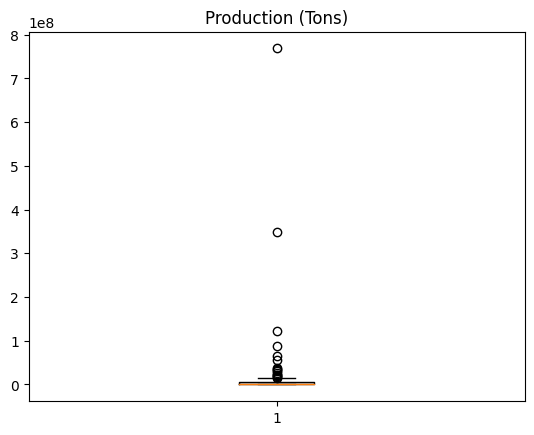

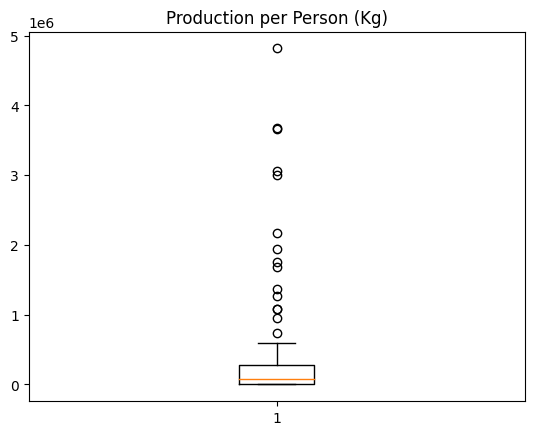

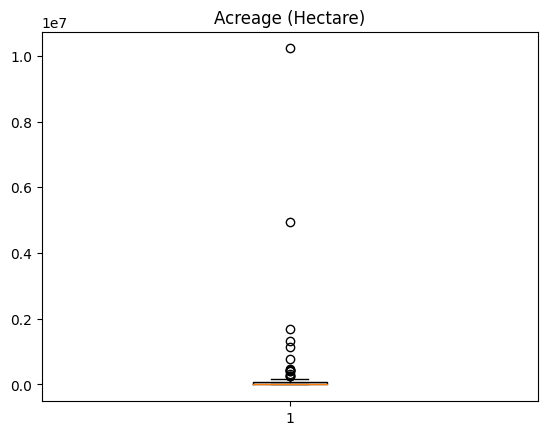

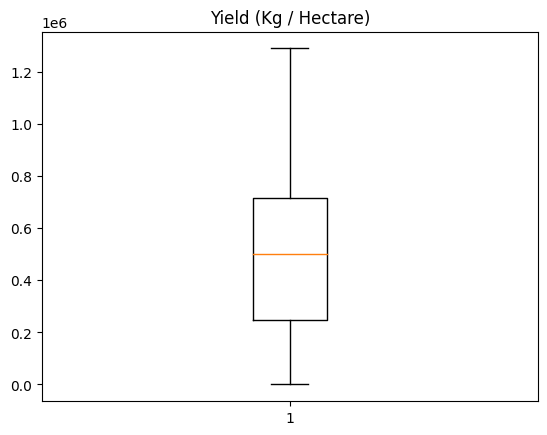

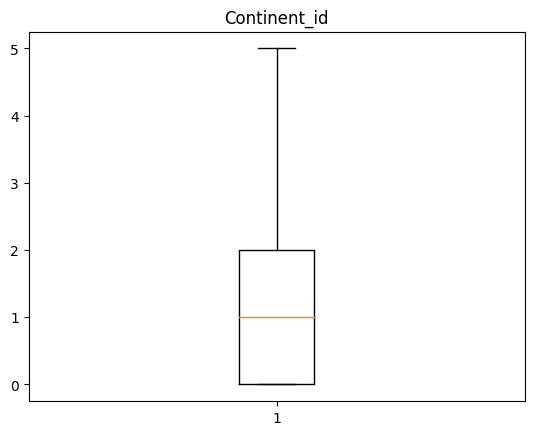

In [45]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Specify the columns to check for outliers
columns_to_check = ['Production (Tons)', 'Production per Person (Kg)', 'Acreage (Hectare)', 'Yield (Kg / Hectare)', 'Continent_id']

# Create a box plot for each column
for column in columns_to_check:
    # Filter out null values and extract the column values as a list
    values = df.select(col(column).cast("double")).filter(col(column).isNotNull()).rdd.flatMap(lambda x: x).collect()

    # Create the box plot
    plt.figure()
    plt.boxplot(values)
    plt.title(column)
    plt.show()


In [46]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import numpy as np

# Specify the columns to check for outliers
columns_to_check = ['Production (Tons)', 'Production per Person (Kg)', 'Acreage (Hectare)']

# Define a function to calculate the percentage of outliers
def calculate_outlier_percentage(values):
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [x for x in values if x < lower_bound or x > upper_bound]
    outlier_percentage = (len(outliers) / len(values)) * 100

    return outlier_percentage, lower_bound, upper_bound

# Create a box plot for each column
for column in columns_to_check:
    # Filter out null values and extract the column values as a list
    values = df.select(col(column).cast("double")).filter(col(column).isNotNull()).rdd.flatMap(lambda x: x).collect()

    # Calculate the percentage of outliers
    outlier_percentage, lower_bound, upper_bound = calculate_outlier_percentage(values)
    print(f"Outlier percentage in {column}: {outlier_percentage:.2f}%")

    # Print the outlier rows
    outliers = df.filter((col(column).cast("double") < lower_bound) | (col(column).cast("double") > upper_bound))
    outliers.show()


Outlier percentage in Production (Tons): 15.53%
+---+--------------------+-------------+-----------------+--------------------------+-----------------+--------------------+------------+
|_c0|             Country|    Continent|Production (Tons)|Production per Person (Kg)|Acreage (Hectare)|Yield (Kg / Hectare)|Continent_id|
+---+--------------------+-------------+-----------------+--------------------------+-----------------+--------------------+------------+
|  0|              Brazil|South America|     7.68678382E8|                 3668531.0|      1.0226205E7|            751675.0|         3.0|
|  1|               India|         Asia|        3.48448E8|                  260721.0|        4950000.0|            703935.0|         1.0|
|  2|               China|         Asia|     1.23059739E8|                   88287.0|        1675215.0|            734591.0|         1.0|
|  3|            Thailand|         Asia|      8.7468496E7|                 1264303.0|        1336575.0|            654422.0|

- I checked out a few countries and it appears realistic, so I've decided to leave the outliers in place.


# Data Distribution

In [47]:
# Describe the DataFrame
description = df.describe()

# Show the description
description.show()


+-------+-----------------+-----------+-------------+-------------------+--------------------------+------------------+--------------------+------------------+
|summary|              _c0|    Country|    Continent|  Production (Tons)|Production per Person (Kg)| Acreage (Hectare)|Yield (Kg / Hectare)|      Continent_id|
+-------+-----------------+-----------+-------------+-------------------+--------------------------+------------------+--------------------+------------------+
|  count|              103|        103|          103|                103|                       103|               103|                 103|               103|
|   mean|             51.0|       null|         null|1.832407203883495E7|         408476.3495145631|249898.10784313726|   501850.1960784314|1.2427184466019416|
| stddev|29.87752778706208|       null|         null|8.379760336331873E7|         863610.5681200195|1131416.1383051905|   315395.4397076675|1.2792922324586107|
|    min|                0|Afghanistan| 

In [48]:
from pyspark.sql.functions import count

country_counts = df.groupBy('Country').agg(count('*').alias('Count')).orderBy('Count', ascending=False)

# Show the value counts
country_counts.show()


+-------------+-----+
|      Country|Count|
+-------------+-----+
|Côte d'Ivoire|    1|
|         Chad|    1|
|     Paraguay|    1|
|        Yemen|    1|
|      Senegal|    1|
|       Guyana|    1|
|  Philippines|    1|
|     Djibouti|    1|
|     Malaysia|    1|
|    Singapore|    1|
|         Fiji|    1|
|       Malawi|    1|
|         Iraq|    1|
|     Cambodia|    1|
|  Afghanistan|    1|
|       Rwanda|    1|
|        Sudan|    1|
|    Sri Lanka|    1|
|       Taiwan|    1|
|     Dominica|    1|
+-------------+-----+
only showing top 20 rows



In [49]:
from pyspark.sql.functions import count

continent_counts = df.groupBy('Continent').agg(count('*').alias('Count')).orderBy('Count', ascending=False)

# Show the value counts
continent_counts.show()

+-------------+-----+
|    Continent|Count|
+-------------+-----+
|       Africa|   39|
|         Asia|   25|
|North America|   22|
|South America|   11|
|      Oceania|    4|
|       Europe|    2|
+-------------+-----+



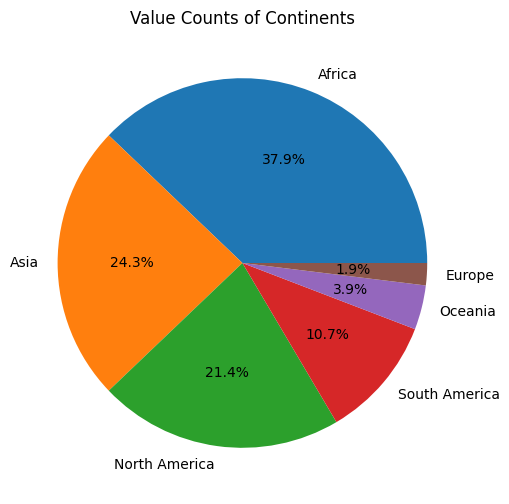

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the continent_counts DataFrame to a Pandas DataFrame for plotting
continent_counts_pd = continent_counts.toPandas()

# Plot the value counts as a pie chart
plt.figure(figsize=(10, 6))
plt.pie(continent_counts_pd['Count'], labels=continent_counts_pd['Continent'], autopct='%1.1f%%')
plt.title('Value Counts of Continents')
plt.show()


# Analysis

## Descriptive Analysis Questions:

### 1. What is the distribution of sugar cane production among the top 10 countries?
   - Columns used: Rank of Most Producing Sugarcane Country, Country Name, Production in Tons


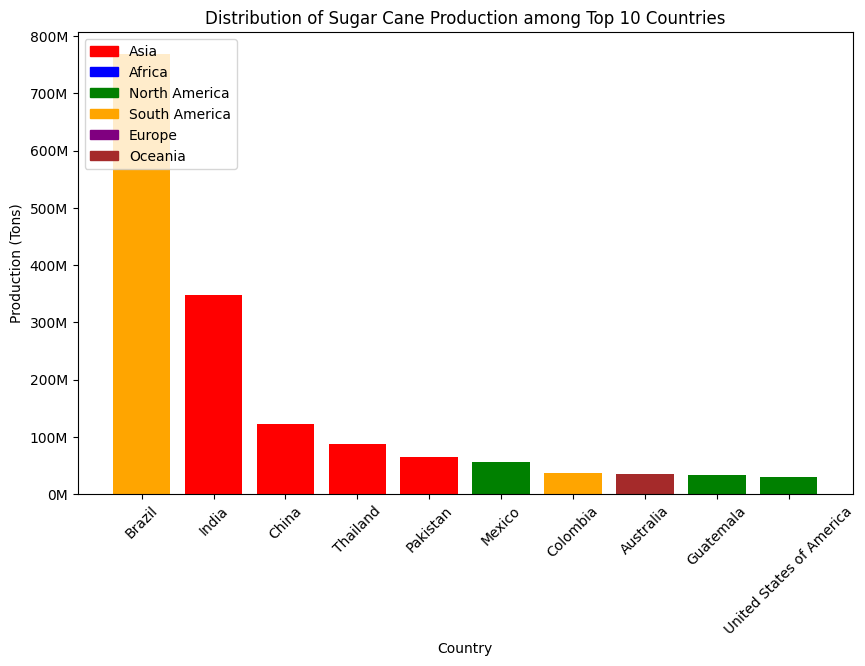

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from pyspark.sql.functions import desc

# Sort the DataFrame by "Production (Tons)" column in descending order
sorted_df = df.orderBy(desc("Production (Tons)"))

# Select the top 10 countries with highest sugar cane production
top_10_countries = sorted_df.select("Country", "Continent", "Production (Tons)").limit(10).toPandas()

# Define the colors for each continent
continent_colors = {
    "Asia": "red",
    "Africa": "blue",
    "North America": "green",
    "South America": "orange",
    "Europe": "purple",
    "Oceania": "brown"
}

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Function to format y-axis labels in millions
def millions_formatter(x, pos):
    'The two args are the value and tick position'
    return f'{x / 1e6:.0f}M'

# Set the formatter for the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Iterate over the top 10 countries and plot the bar chart
for i, row in top_10_countries.iterrows():
    country = row["Country"]
    production = row["Production (Tons)"]
    continent = row["Continent"]

    # Set the color based on the continent
    color = continent_colors.get(continent, "gray")

    # Plot the bar
    ax.bar(country, production, color=color)

# Set the labels and title
plt.xlabel("Country")
plt.ylabel("Production (Tons)")
plt.title("Distribution of Sugar Cane Production among Top 10 Countries")

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Create the legend
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in continent_colors.values()]
legend_texts = continent_colors.keys()
plt.legend(legend_labels, legend_texts, loc='upper left')

# Show the plot
plt.show()


Based on the analysis and the provided graph, we observe that Brazil has the highest sugar cane production among the selected countries. It is followed by India and China, which rank second and third, respectively, in terms of sugar cane production. Interestingly, the United States ranks tenth in terms of sugar cane production among these countries.

### 2. Is there a correlation between land acreage and sugar cane production among these countries?
   - Columns used: Country Name, Land Area Acreage (Hectare), Production in Tons


In [52]:
from pyspark.sql.functions import col

# Select the columns of interest
columns = ['Country', 'Acreage (Hectare)', 'Production (Tons)']

# Filter out rows with null values in the selected columns
filtered_df = df.select(columns).filter(col('Acreage (Hectare)').isNotNull() & col('Production (Tons)').isNotNull())

# Calculate the correlation between land acreage and sugar cane production
correlation = filtered_df.corr('Acreage (Hectare)', 'Production (Tons)')

# Print the correlation value
print("Correlation between land acreage and sugar cane production:", correlation)


Correlation between land acreage and sugar cane production: 0.9973140201006786


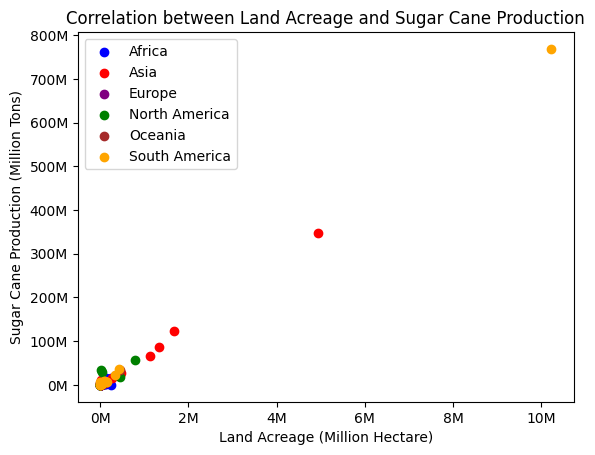

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

# Select the columns of interest
columns = ['Acreage (Hectare)', 'Production (Tons)', 'Continent']

# Filter out rows with null values in the selected columns
filtered_df = df.select(columns).filter(col('Acreage (Hectare)').isNotNull() & col('Production (Tons)').isNotNull())

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = filtered_df.toPandas()

# Extract the columns as NumPy arrays
acreage = pandas_df['Acreage (Hectare)'].values
production = pandas_df['Production (Tons)'].values
continent = pandas_df['Continent'].values

# Define the colors for each continent
continent_colors = {
    'Asia': 'red',
    'Africa': 'blue',
    'North America': 'green',
    'South America': 'orange',
    'Europe': 'purple',
    'Oceania': 'brown'
}

# Create a scatter plot
fig, ax = plt.subplots()
for c in np.unique(continent):
    indices = np.where(continent == c)
    ax.scatter(acreage[indices], production[indices], label=c, color=continent_colors.get(c, 'gray'))

# Set the labels and title
plt.xlabel('Land Acreage (Million Hectare)')
plt.ylabel('Sugar Cane Production (Million Tons)')
plt.title('Correlation between Land Acreage and Sugar Cane Production')

# Add legend
plt.legend()

# Format tick labels
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}M'.format(x/1e6)))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:,.0f}M'.format(y/1e6)))

# Show the plot
plt.show()

Based on the graph, it is evident that there exists a clear linear relationship between land acreage (hectare) dedicated to sugar cane production and the resulting production (tons). As the land acreage increases, there is a corresponding increase in sugar cane production, indicating a positive correlation between these variables. The linear nature of the relationship suggests that the production output tends to increase proportionally with the expansion of land dedicated to sugar cane cultivation.

### 3. Is there a relationship between the productivity of workers and sugar cane production among these countries?
   - Columns used: Country Name, Production in Tons, Yield (kg/Hectare)


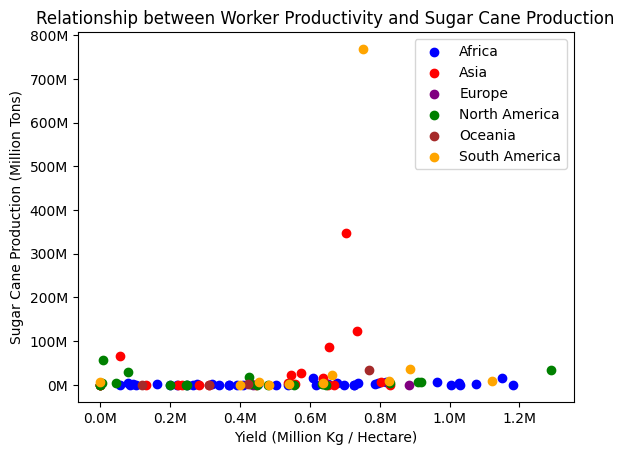

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

# Select the columns of interest
columns = ['Production (Tons)', 'Yield (Kg / Hectare)', 'Continent']

# Filter out rows with null values in the selected columns
filtered_df = df.select(columns).filter(col('Production (Tons)').isNotNull() & col('Yield (Kg / Hectare)').isNotNull())

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = filtered_df.toPandas()

# Extract the columns as NumPy arrays
production = pandas_df['Production (Tons)'].values
yield_per_hectare = pandas_df['Yield (Kg / Hectare)'].values
continent = pandas_df['Continent'].values

# Define the colors for each continent
continent_colors = {
    'Asia': 'red',
    'Africa': 'blue',
    'North America': 'green',
    'South America': 'orange',
    'Europe': 'purple',
    'Oceania': 'brown'
}

# Create a scatter plot
fig, ax = plt.subplots()
for c in np.unique(continent):
    indices = np.where(continent == c)
    ax.scatter(yield_per_hectare[indices], production[indices], label=c, color=continent_colors.get(c, 'gray'))

# Set the labels and title
plt.xlabel('Yield (Million Kg / Hectare)')
plt.ylabel('Sugar Cane Production (Million Tons)')
plt.title('Relationship between Worker Productivity and Sugar Cane Production')

# Add legend
plt.legend()

# Format tick labels
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.1f}M'.format(x/1e6)))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:,.0f}M'.format(y/1e6)))

# Show the plot
plt.show()

Based on the graph, there appears to be no clear relationship between the production (tons) of sugar cane and the yield (kg/hectare) within the given dataset. The data points seem to be scattered without any discernible pattern or trend. This suggests that increasing the yield per hectare does not necessarily result in a corresponding increase in sugar cane production.

## Exploratory Analysis Questions:

### 1. How does the production of sugar cane vary across continents?
   - Columns used: Continent Name, Production in Tons


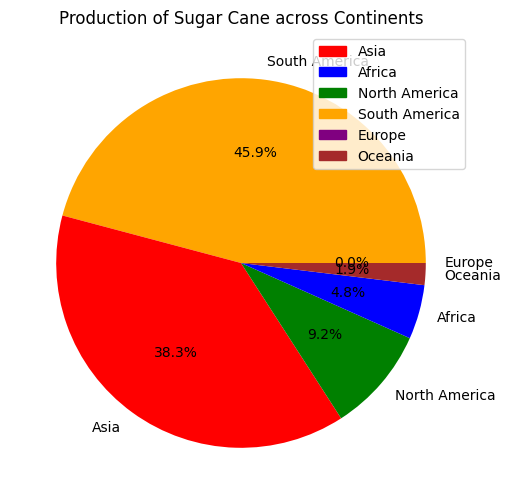

In [56]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pandas as pd

# Select the columns of interest
columns = ['Continent', 'Production (Tons)']

# Filter out rows with null values in the selected columns
filtered_df = df.select(columns).filter(col('Production (Tons)').isNotNull())

# Group by continent and calculate the total production of sugar cane
continent_production = filtered_df.groupBy('Continent').sum('Production (Tons)').withColumnRenamed('sum(Production (Tons))', 'Total Production').orderBy('Total Production', ascending=False)

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = continent_production.toPandas()

# Define the continent colors
continent_colors = {
    'Asia': 'red',
    'Africa': 'blue',
    'North America': 'green',
    'South America': 'orange',
    'Europe': 'purple',
    'Oceania': 'brown'
}

# Create a pie chart
fig, ax = plt.subplots(figsize=(10, 6))
plt.pie(pandas_df['Total Production'], labels=pandas_df['Continent'], colors=[continent_colors[cont] for cont in pandas_df['Continent']], autopct='%1.1f%%')

plt.title('Production of Sugar Cane across Continents')

# Add legend with continent colors
legend_labels = [plt.Rectangle((0, 0), 1, 1, color=continent_colors[cont]) for cont in continent_colors]
plt.legend(legend_labels, continent_colors.keys())

# Display the plot
plt.show()

Most of the sugar cane production comes from South America, accounting for 45% of the total production. Asia follows closely with 38%. Interestingly, the graph reveals that Europe has the least contribution to sugar cane production.

### 2. Is there a correlation between the yield of sugar cane and the production per person among these countries?
   - Columns used: Country Name, Production per Person (kg), Yield (kg/Hectare)
italicized text

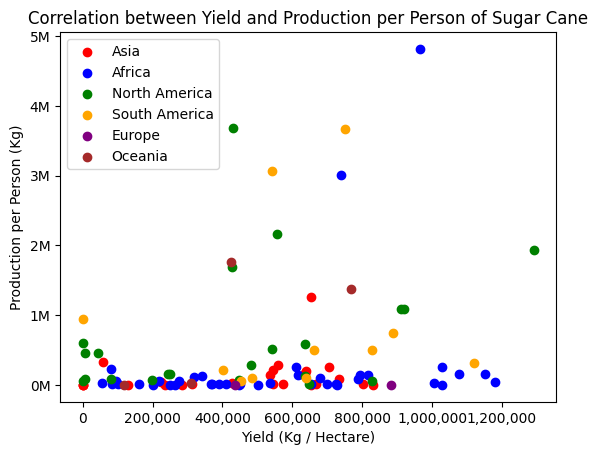

In [89]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Select the columns of interest
columns = ['Country', 'Production per Person (Kg)', 'Yield (Kg / Hectare)', 'Continent']

# Filter out rows with null values in the selected columns
filtered_df = df.select(columns).filter(col('Production per Person (Kg)').isNotNull() & col('Yield (Kg / Hectare)').isNotNull())

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = filtered_df.toPandas()

# Define the continent colors
continent_colors = {
    'Asia': 'red',
    'Africa': 'blue',
    'North America': 'green',
    'South America': 'orange',
    'Europe': 'purple',
    'Oceania': 'brown'
}

# Extract the columns as NumPy arrays
production_per_person = pandas_df['Production per Person (Kg)'].values
yield_per_hectare = pandas_df['Yield (Kg / Hectare)'].values
continents = pandas_df['Continent'].values

# Create a scatter plot
fig, ax = plt.subplots()
for continent in continent_colors:
    mask = (continents == continent)
    ax.scatter(yield_per_hectare[mask], production_per_person[mask], color=continent_colors[continent], label=continent)

# Format the y-axis in millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:,.0f}M'.format(y/1e6)))
# Format the x-axis in kilograms
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

plt.xlabel('Yield (Kg / Hectare)')
plt.ylabel('Production per Person (Kg)')
plt.title('Correlation between Yield and Production per Person of Sugar Cane')
plt.legend()
plt.show()

In this graph, we cannot observe a clear relationship between "Production per Person (Kg)" and "Yield (Kg / Hectare)". The data points appear to be scattered without a discernible pattern or trend. Therefore, it is difficult to establish a direct correlation between these two variables based on the given data.

## Predictive Analysis Questions:

### 1. Can we predict the sugar cane production of a country based on its land acreage and worker productivity?
   - Columns used: Country Name, Land Area Acreage (Hectare), Yield


In [98]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Select the columns of interest
columns = ['Country', 'Acreage (Hectare)', 'Yield (Kg / Hectare)', 'Production (Tons)']

# Create a vector assembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=['Acreage (Hectare)', 'Yield (Kg / Hectare)'], outputCol='features')

# Transform the DataFrame to include the features vector column
feature_df = assembler.transform(df.select(columns))

# Split the data into training and test sets (70% for training, 30% for testing)
train_data, test_data = feature_df.randomSplit([0.7, 0.3], seed=42)

# Create a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='Production (Tons)')

# Train the model using the training data
model = lr.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model by calculating the root mean squared error (RMSE)
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='Production (Tons)', metricName='rmse')
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Print the coefficients and intercept of the linear regression model
print("Coefficients: ", model.coefficients)
print("Intercept: ", model.intercept)

Root Mean Squared Error (RMSE): 5096963.97
Coefficients:  [74.5996486570391,5.110552060278908]
Intercept:  -2717695.714997728


The Root Mean Squared Error (RMSE) is a measure of the difference between the predicted values and the actual values. In this case, the RMSE value of 5096963.97 indicates that, on average, the predicted sugar cane production values differ from the actual values by approximately 5,096,963.97 tons.

The coefficients of the linear regression model indicate the relationship between the independent variables (land acreage and worker productivity) and the dependent variable (sugar cane production). The coefficient values are as follows: 74.5996486570391 for land acreage and 5.110552060278908 for worker productivity. This means that for every 1 unit increase in land acreage, the predicted sugar cane production increases by approximately 74.6 tons, holding other factors constant. Similarly, for every 1 unit increase in worker productivity, the predicted sugar cane production increases by approximately 5.1 tons, holding other factors constant.

The intercept of -2717695.714997728 represents the predicted sugar cane production when both land acreage and worker productivity are zero.

Based on these results, we can conclude that there is a relationship between land acreage, worker productivity, and sugar cane production. The linear regression model can be used to predict the sugar cane production of a country based on its land acreage and worker productivity. However, the RMSE value suggests that the model's predictions may have a relatively high level of error, indicating that there may be other factors not accounted for in the model that influence sugar cane production.

### 2. Can we build a model to predict the yield of sugar cane based on a country's production per person and land acreage?
   - Columns used: Country Name, Production per Person (kg), Land Area Acreage (Hectare), Yield (kg/Hectare)


In [104]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Select the columns of interest
columns = ['Country', 'Production per Person (Kg)', 'Acreage (Hectare)', 'Yield (Kg / Hectare)']

# Create a vector assembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=['Production per Person (Kg)', 'Acreage (Hectare)'], outputCol='features')

# Transform the DataFrame to include the features vector column
feature_df = assembler.transform(df.select(columns))

# Split the data into training and test sets (70% for training, 30% for testing)
train_data, test_data = feature_df.randomSplit([0.7, 0.3], seed=42)

# Create a RandomForestRegressor model
rf = RandomForestRegressor(featuresCol='features', labelCol='Yield (Kg / Hectare)')

# Train the model using the training data
model = rf.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model by calculating the root mean squared error (RMSE)
evaluator = RegressionEvaluator(labelCol='Yield (Kg / Hectare)', metricName='rmse')
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 267070.16


The Root Mean Squared Error (RMSE) is a measure of the average deviation of the predicted values from the actual values in the test dataset. In the context of this model, an RMSE of 267070.16 indicates that, on average, the predicted yield of sugar cane based on the production per person and land acreage is off by approximately 267070.16 kg/hectare. A lower RMSE indicates better model performance, as it represents smaller prediction errors.

Based on the given RMSE value, it suggests that the model is able to predict the yield of sugar cane with a reasonable level of accuracy using the features of production per person and land acreage. However, it's important to consider the context and domain knowledge when interpreting the results. Other factors not included in the model may also have an impact on the yield of sugar cane. Therefore, while the model shows promise, further analysis and refinement may be necessary to build a more accurate and reliable predictive model.